# Assignment 1: MLPs and Backpropagation
### <font color='blue'> Due on November 9th, 2025 (23:59:59) </font>

Welcome to Comp541: Deep Learning Course!

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning.

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [38]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\MKANTAR21\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://towardsdatascience.com/word-vectors-intuition-and-co-occurence-matrixes-a7f67cae16cd/)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [39]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [40]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [41]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    # ------------------
    # Write your implementation here.
    num_corpus_words = 0

    for docs in corpus:
        for word in docs:


            if word not in corpus_words:
                corpus_words.append(word)
                num_corpus_words += 1
                
                
    corpus_words.sort()

    

    #print("Num of distinct words: ", num_corpus_words)
    #print("Distinct words: ", corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [42]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [43]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    # ------------------
    # Write your implementation here.


    M = np.zeros((num_words, num_words))
    for i in range(num_words):
        word2ind[words[i]] = i


    for docs in corpus:
        doc_length = len(docs)

        for index, word in enumerate(docs):
            word_index = word2ind[word]

            start = max(0, index - window_size) 
            end = min(doc_length, index + window_size + 1) 

            for i in range(start, end):
                if i != index:
                    cooccured_word = docs[i]
                    cooccured_word_index = word2ind[cooccured_word]
                    M[word_index][cooccured_word_index] += 1


    # ------------------

    return M, word2ind

In [44]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [45]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.

    
    Truncated_SVD = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = Truncated_SVD.fit_transform(M)



    # ------------------

    print("Done.")
    return M_reduced

In [46]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [47]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.

    

    for word in words:
        if word in word2ind:

            index = word2ind[word]
            x = M_reduced[index][0]
            y = M_reduced[index][1]

            
            plt.scatter(x, y, marker='x', color='red')
            plt.text(x, y, word, fontsize=9)


    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


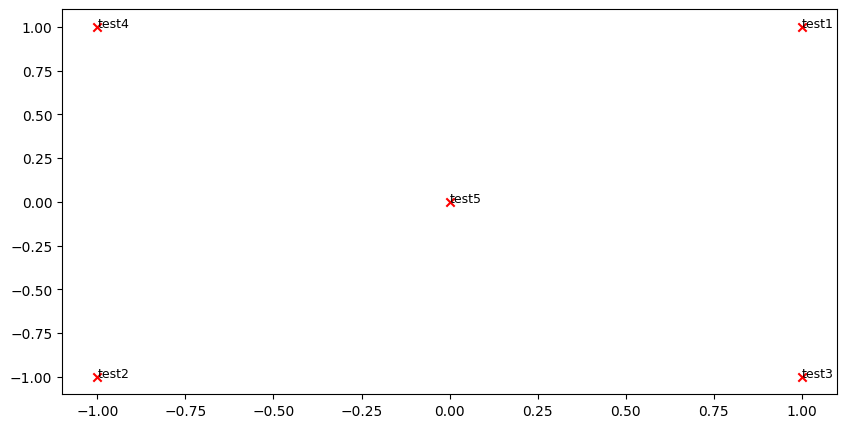

In [48]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


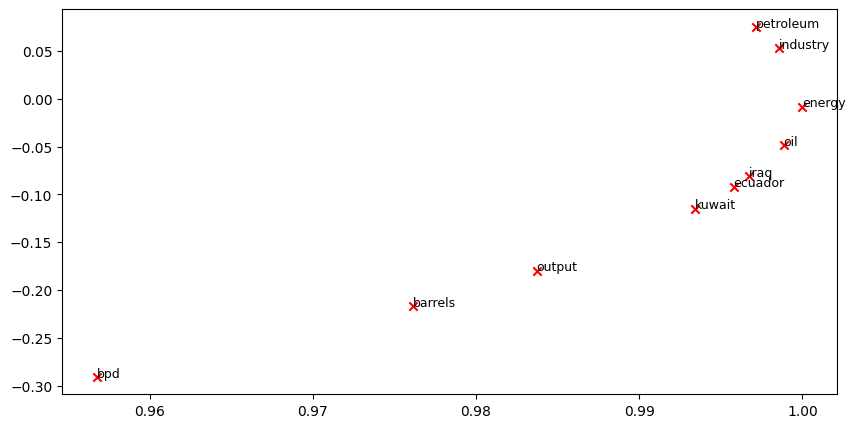

In [49]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Answer</font>

The plot shows two groups. On the left are "barrels", "bpd", and "output" (words about amount and production). On the right top are "oil", "energy", "iraq", "ecuador", and "kuwait" (words about oil and places). I expected "petroleum" more close to "oil" or "iraq". This difference happens because model has many word meanings, so some real connections between some words may get lost due to the fact that other ones more similar. Also, dimension of 2D plot maybe insufficient to demonstrate connections between words.

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [50]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [51]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [52]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [53]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

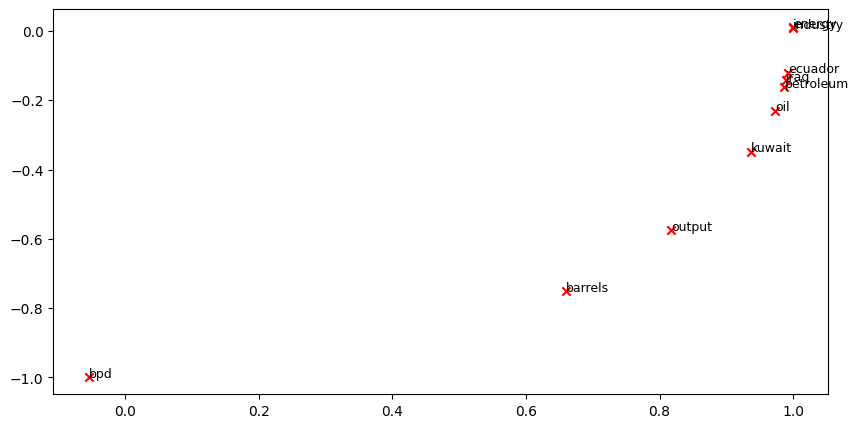

In [54]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Answer</font>
The GloVe plot shows two groups. One cluster has "barrels", "bpd", and "output" but has distance a lot. Other group has "oil", "energy", "petroleum", and country names like "iraq", "ecuador", "kuwait" directly expected meanings as before. 
This differs from the earlier co-occurrence plot because GloVe embeddings has more contextual connection, not just local word windows. This factor can change where words plotted in the 2D space.

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [55]:
# ------------------
# Write your implementation here.



# animal vs device
print("Most similar words to 'mouse':")
pprint.pprint(wv_from_bin.most_similar("mouse", topn=10))
print("-" * 80)

# language vs snake
print("Most similar words to 'python':")
pprint.pprint(wv_from_bin.most_similar("python", topn=10))
print("-" * 80)

# season vs coil vs leap
print("Most similar words to 'spring':")
pprint.pprint(wv_from_bin.most_similar("spring", topn=10))
print("-" * 80)



# ------------------

Most similar words to 'mouse':
[('mice', 0.65809565782547),
 ('keyboard', 0.5548279285430908),
 ('rat', 0.5433950424194336),
 ('rabbit', 0.5192376971244812),
 ('cat', 0.5077414512634277),
 ('cursor', 0.5058691501617432),
 ('trackball', 0.5048902630805969),
 ('joystick', 0.49841049313545227),
 ('mickey', 0.47242841124534607),
 ('clicks', 0.4722806513309479)]
--------------------------------------------------------------------------------
Most similar words to 'python':
[('monty', 0.6892719268798828),
 ('spamalot', 0.5611781477928162),
 ('cleese', 0.5454379916191101),
 ('php', 0.5255268812179565),
 ('pythons', 0.5076838731765747),
 ('perl', 0.4999808371067047),
 ('scripting', 0.48510175943374634),
 ('skit', 0.47538259625434875),
 ('reticulatus', 0.47097331285476685),
 ('crocodile', 0.4570692777633667)]
--------------------------------------------------------------------------------
Most similar words to 'spring':
[('summer', 0.802531361579895),
 ('autumn', 0.7510949373245239),
 ('winter'

#### <font color="red">Answer.</font>

The word "mouse" shows clear evidence of two distinct meanings in its top-10 similar words.
This example works well because both meanings of "mouse" (computer and animal) are frequently used in daily life. That resulsts with word embeddings to capture both contexts.
Many polysemous words display only their dominant meaning in word embeddings because the GloVe algorithm tends to learn the more frequently occurring sense from the training corpus.
This demonstrates how word embeddings can capture multiple word meanings, but their effectiveness depends much on how different meanings are represented in the training data.

### Question 2.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [56]:
# ------------------
# Write your implementation here.


print("Distances between word pairs up and down:")
pprint.pprint(wv_from_bin.distance("up","down"))


print("Distances between word pairs above and down:")
pprint.pprint(wv_from_bin.distance("above","down"))


print("Distances between word pairs up and above:")
pprint.pprint(wv_from_bin.distance("up","above"))
# ------------------

Distances between word pairs up and down:
0.15407651662826538
Distances between word pairs above and down:
0.44264233112335205
Distances between word pairs up and above:
0.46239280700683594


#### <font color="red">Answer.</font>

My example uses w1="up", w2="above" (synonyms), and w3="down" (antonym). The cosine distance shows "up" is closer to "down" than to "above". This happens because embeddings use context. 
In the corpus, "up" and "down" often appear in the same context and co-occur. For Example "go up/down", "up or down" so their vectors are similar. 
On the other hand, "above" is used in different patterns (more formal like "as shown above"), while "up" is common in phrasal verbs ("set up", "pick up"). Because cosine similarity reflects context, not a dictionary sense.
Antonyms that share context can be close, and synonyms with different usage can be farther. 

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [57]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978679299354553),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754295349121),
 ('throne', 0.5775109529495239),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595390319824),
 ('daughter', 0.5399127006530762),
 ('kingdom', 0.5318052172660828),
 ('mother', 0.516854465007782),
 ('crown', 0.5164472460746765)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Answer</font>
(== stands for similar )

The core idea is that the vector difference, between man and king should be semantically similar to the vector difference between woman and x. This relationship can be expressed as the equation k - m == x - w. By rearranging this expression to solve for the vector x, we get x == k - m + w. The most_similar function computes this target vector (king + woman - man) and then look for the vocabulary for the word vector x that has the highest cosine similarity value
Therefore, the expression I am maximizing the cosine similarity with x for is k + w - m.

### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [58]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['ankara', 'germany'], negative=['turkey']))

# ------------------

[('berlin', 0.7247796058654785),
 ('bonn', 0.6729719638824463),
 ('german', 0.614696204662323),
 ('frankfurt', 0.5699551701545715),
 ('vienna', 0.5671765208244324),
 ('munich', 0.561138391494751),
 ('leipzig', 0.5423043966293335),
 ('schroeder', 0.5354014039039612),
 ('gerhard', 0.5332780480384827),
 ('helmut', 0.5269496440887451)]


#### <font color="red">Answer</font>
(== stands for similar)

The core idea is that the vector difference from ankara to turkey should be similar to the vector difference from x to germany. Let a, T, g, and x be the word vectors for “ankara” “turkey” “germany” and the answer. I want T − a == g − x. Rearranging to solve for x gives x == g − T + a. The most_similar function find exactly this vector (ankara + germany − turkey). Then, finds the word that vector has the highest cosine similarity. In this case, the most similar match is “berlin” that fits the capital of country.


### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [59]:
# ------------------
# Write your implementation here.


pprint.pprint(wv_from_bin.most_similar(positive=['knock-out', 'chess'], negative=['boxing']))


# ------------------

[('best-of-three', 0.42934542894363403),
 ('round-robin', 0.41633278131484985),
 ('play-in', 0.40797367691993713),
 ('double-elimination', 0.40359076857566833),
 ('home-and-away', 0.3882964253425598),
 ('olympiads', 0.38574549555778503),
 ('quarter-final', 0.37177151441574097),
 ('melon', 0.3696978986263275),
 ('two-legged', 0.3651592433452606),
 ('four-team', 0.36373913288116455)]


#### <font color="red">Answer</font>

Aimed analogy: boxing : knock-out :: chess : checkmate.
However, the model returns "best-of-three" (and other tournament related words) as the closest words. According to the vectors model says "best-of-three"  that is incorrect. This happens because GloVe vectors shows contexts in the training corpus. "knock-out" maybe often appears in tournament or match-format contexts (like best-of-three). Also, "chess" appears in tournament contexts, so the vectors give output like tournament related words rather than the game ending relation (knock-out == checkmate). Corpus bias also contributes to this wrong answer.


### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [60]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.606891930103302),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363887548446655),
 ('mother', 0.5321308374404907),
 ('employer', 0.5127025246620178),
 ('teacher', 0.5099577307701111),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019455552101135),
 ('nurses', 0.49705713987350464)]

[('workers', 0.6113258600234985),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940454065799713)]


#### <font color="red">Answer</font>
The two lists are different obviously. The female like results include caregiving and family terms (nurse, pregnant, mother, homemaker, child), while the male like results include industrial job terms (mechanic, laborer, factory, working). This reflects gender bias in the embeddings. The training corpus uses women more often in caregiving similar contexts. On the other hand, men more often in technical contexts, so the model learns and generates those stereotyped associations.

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [61]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['programmer', 'woman'], negative=['man']))
pprint.pprint(wv_from_bin.most_similar(positive=['programmer', 'man'], negative=['woman']))

# ------------------

[('programmers', 0.535283088684082),
 ('translator', 0.47437363862991333),
 ('freelance', 0.47011977434158325),
 ('educator', 0.4551156759262085),
 ('animator', 0.44057154655456543),
 ('aspiring', 0.4394908547401428),
 ('software', 0.4282291829586029),
 ('librarian', 0.4195935130119324),
 ('designer', 0.4158250391483307),
 ('illustrator', 0.41235044598579407)]
[('programmers', 0.529083788394928),
 ('engineer', 0.48715341091156006),
 ('creator', 0.483517050743103),
 ('software', 0.47897082567214966),
 ('computer', 0.46826446056365967),
 ('animator', 0.44055163860321045),
 ('compiler', 0.4270141124725342),
 ('programming', 0.40389901399612427),
 ('developer', 0.40236783027648926),
 ('hacker', 0.39982911944389343)]


#### <font color="red">Answer</font>
This example demonstrates gender bias in the word embeddings related to the programming profession. When we compute the vector analogy "programmer - man + woman", the model returns words like "translator", "freelance", "educator", and "designer" (often associated with less technical or more creative). In contrast, "programmer - woman + man" returns words like "engineer", "software", "computer", "developer" (core technical and engineering terms). 
This bias shows that women in technical computing roles appeared less in corpus in the training data. The word vectors learn these statistical associations from text corpuses where programming and technical roles have been male-dominated in history. while women has more association with support, creative, or educational positions. This shows how word2vec embeddings can infer and relate occupational gender stereotypes, demonstrating the gender inequality present in real-world technology sectors.

### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Answer</font>


Bias is happening in word vectors because they learn from the training corpus. This text reflects stereotypes and patterns. For example, if many documents say "women" near words like "nurse" or "mother", and say "men" near words like "engineer" or "factory", the embeddings learn these connections. The GloVe algorithm captures co-occurrence patterns ,so it picks up both good patterns and problematic ones like gender stereotypes 
To check this bias, we could use the Word Embedding Association Test (WEAT) example https://github.com/chadaeun/weat_replication . This test measures how strongly different groups (like male vs. female names) are linked to different attributes in some contexts. I check tihs with one by one cosine similarity results between different words. If the test shows that certain groups systematically connect to positive or negative biases. We have proof that societal biases from the training text are used in the embedding space.

## Part 3: Sentiment Analysis (15 points)

Lastly, you will implement a simple sentiment classifier **from scratch** by using the Deep Averaging Network (DAN) proposed in the [paper](https://aclanthology.org/P15-1162.pdf). The model is based on the following three steps:

- Take the vector average of the embeddings associated with the words in the inputs
- Pass that average vector through one or more feed-forward layers
- Perform linear classification on the final layer’s representation


Here, you will use Stanford Sentiment Treebank (SST) dataset but note that in this dataset, the sentiment levels are originally represented with real values. Hence, you need to discretize these values into the following five classes:


- 0: "very negative" ($\le 0.2$),
- 1: "negative" ($\le 0.4$),
- 2: "neutral" ($\le 0.6$),
- 3: "positive" ($\le 0.8$),
- 4: "very positive" ($>$ 0.8)


### Download the Dataset
You can download the dataset [here](https://nlp.stanford.edu/sentiment/) (Download the "**Main zip file with readme (6mb)**" version). Please read `README.txt` in details, that comes with the .zip folder.

**Create a /data directory to store your SST data and unzip your downloaded folder there.** Your data path should be like following:

```
./comp541-441/assignment1/data
                            └── stanfordSentimentTreebank
                                ├── README.txt
                                ├── SOStr.txt
                                ├── STree.txt
                                ├── datasetSentences.txt
                                ├── datasetSplit.txt
                                ├── dictionary.txt
                                ├── original_rt_snippets.txt
                                └── sentiment_labels.txt
```

Or, you can simply use Huggingface's **datasets** library if you are familiar.

### What to show
In your work, perform the following experiments and explain your findings:

- Provide your loss curves by plotting them clearly,
- Play with the number of layers,
- Try with embeddings trained on different corpuses
- Test with the GloVe embeddings and the embeddings formed through the word co-occurrence matrix. Report your results on the test set for both types of embeddings (make sure to use the same test set for both, to ensure a fair comparison).

In [62]:
# ------------------
# Start your implementation here.


# Import additional libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)



# ------------------

## Load Stanford Sentiment Treebank Dataset

In [63]:

def load_sst_data(data_path='./data/stanfordSentimentTreebank'):
    
    
    #Load Stanford Sentiment Treebank dataset
    # Read sentences
    sentences_data = pd.read_csv(os.path.join(data_path, 'datasetSentences.txt'), sep='\t')
    

    # Read sentiment labels
    labels_data = pd.read_csv(os.path.join(data_path, 'sentiment_labels.txt'), sep='|')
    

    # Read dictionary (phrase to phrase_id mapping)
    dictionary_data = pd.read_csv(os.path.join(data_path, 'dictionary.txt'), sep='|', names=['phrase', 'phrase_id'])
    

    # Read split information
    split_data = pd.read_csv(os.path.join(data_path, 'datasetSplit.txt'), sep=',')
    

    # Merge data
    data = sentences_data.merge(split_data, on='sentence_index')
    data = data.merge(dictionary_data, left_on='sentence', right_on='phrase')
    data = data.merge(labels_data, left_on='phrase_id', right_on='phrase ids')
    



    # Discrete sentiment into 5 classes
    def discrete_sentiment(value):
        if value <= 0.2:
            return 0  # very negative
        elif value <= 0.4:
            return 1  # negative
        elif value <= 0.6:
            return 2  # neutral
        elif value <= 0.8:
            return 3  # positive
        else:
            return 4  # very positive
    
    data['label'] = data['sentiment values'].apply(discrete_sentiment) 
    

    # Split into train, validation, test
    train_data = data[data['splitset_label'] == 1]
    validation_data = data[data['splitset_label'] == 2]
    test_data = data[data['splitset_label'] == 3]
    

    
    return train_data, validation_data, test_data






## Dataset class

In [64]:

class SentimentDataset(Dataset):

    def __init__(self, data, word_vector, max_length=50):
        self.sentences = data['sentence'].values
        self.labels = data['label'].values
        self.word_vectors = word_vector
        self.max_len = max_length
        

    def __len__(self):
        return len(self.sentences)
    

    def __getitem__(self, idx):
        sentence = self.sentences[idx].lower().split()
        label = self.labels[idx]
        
        # Get word embeddings and average them
        embeddings = []
        for word in sentence:
            try:
                if hasattr(self.word_vectors, 'word_vec'):
                    embeddings.append(self.word_vectors.word_vec(word))
                else:
                    # For co-occurrence embeddings
                    embeddings.append(self.word_vectors[word])
            except (KeyError, IndexError):
                continue
        


        if len(embeddings) == 0:
            # If no words found, zero vector
            embedding_dim = 200 if hasattr(self.word_vectors, 'word_vec') else len(list(self.word_vectors.values())[0])
            avg_embedding = np.zeros(embedding_dim)
        else:
            avg_embedding = np.mean(embeddings, axis=0)
        
        return torch.FloatTensor(avg_embedding), torch.LongTensor([label])[0]





## Deep Averaging Network
https://www.kaggle.com/code/alperkaraca1/deep-averaging-networks-sentiment-analysis

I looked at this website to implement the DAN model


In [65]:

class DAN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(DAN, self).__init__()
        
        layers = []
        current_dimension = input_dim
        

        for i in range(num_layers): 
            layers.append(nn.Linear(current_dimension, hidden_dim)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            current_dimension = hidden_dim
        


        self.hidden_layers = nn.Sequential(*layers) 
        self.output_layer = nn.Linear(current_dimension, output_dim)




    def forward(self, x):

        x = self.hidden_layers(x)
        x = self.output_layer(x)

        return x





## Training function

In [66]:

def training_epoch(model, dataloader, criterion, optimizer, device):
    
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    

    for embedding, label in dataloader:
        embedding, label = embedding.to(device), label.to(device)
        
        optimizer.zero_grad()
        outputs = model(embedding)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    return total_loss / len(dataloader), correct / total




## Evaluation Function

In [67]:

def eval(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    
    for embedding, label in dataloader:

        embedding, label = embedding.to(device), label.to(device)
        outputs = model(embedding)
        
        
        loss = criterion(outputs, label)
        total_loss += loss.item()
        
        
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    


    return total_loss / len(dataloader), correct / total





## Main training 

In [68]:


def training_dan(word_vectors, embedding_name, num_layers=1, num_epoch=20, hidden_dim=128, batch_size=32,device=device):
    
    print(f"Using device: {device}")
    
    # Load data
    train_data, validation_data, test_data = load_sst_data()
    
    # Create datasets
    train_dataset = SentimentDataset(train_data, word_vectors)
    validation_dataset = SentimentDataset(validation_data, word_vectors)
    test_dataset = SentimentDataset(test_data, word_vectors)
    


    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    


    # Get embedding dimension
    sample_embedding, _ = train_dataset[0]
    input_dim = sample_embedding.shape[0]
    
    # Initialize model
    model = DAN(input_dim, hidden_dim, output_dim=5, num_layers=num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    



    # Training loop
    train_losses = []
    validation_losses = []
    train_accs = []
    validation_accs = []
    best_validation_accuracy = 0
    


    for epoch in range(num_epoch):
        
        train_loss, train_acc = training_epoch(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = eval(model, validation_loader, criterion, device)
        

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        train_accs.append(train_acc)
        validation_accs.append(validation_accuracy)
        

        print(f"Epoch {epoch+1}/{num_epoch}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.4f}")
        print()
        

        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), f'best_model_{embedding_name}_{num_layers}layers.pt')
    




    # Load best model and evaluate on test set
    # Get help from: https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model.load_state_dict(torch.load(f'best_model_{embedding_name}_{num_layers}layers.pt'))
    test_loss, test_acc = eval(model, test_loader, criterion, device)
    print(f"Test Accuracy: {test_acc:.4f}")
    


    # Plot loss curves
    # Get help from LLM for good visualization plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves - {embedding_name} ({num_layers} layers)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(validation_accs, label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curves - {embedding_name} ({num_layers} layers)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return test_acc, train_losses, validation_losses


In [69]:
def load_different_glove_embeddings():
    """Load different GloVe embeddings trained on different corpuses"""
    import gensim.downloader as api
    
    # GloVe trained on Twitter 200 dimensional embeddings
 
    wv_from_bin = api.load("glove-twitter-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin
    

## Experiment 1: GloVe embeddings with different number of layers


--------------------------------------------------------------------------------
Experiment 1: GloVe embeddings with 1 layer
--------------------------------------------------------------------------------
Using device: cpu
Epoch 1/20
Train Loss: 1.5052, Train Acc: 0.3282
Validation Loss: 1.4142, Validation Acc: 0.3878

Epoch 2/20
Train Loss: 1.3861, Train Acc: 0.3969
Validation Loss: 1.3465, Validation Acc: 0.4085

Epoch 3/20
Train Loss: 1.3449, Train Acc: 0.4167
Validation Loss: 1.3413, Validation Acc: 0.4014

Epoch 4/20
Train Loss: 1.3228, Train Acc: 0.4227
Validation Loss: 1.3341, Validation Acc: 0.4136

Epoch 5/20
Train Loss: 1.3074, Train Acc: 0.4325
Validation Loss: 1.3234, Validation Acc: 0.4151

Epoch 6/20
Train Loss: 1.2996, Train Acc: 0.4361
Validation Loss: 1.3129, Validation Acc: 0.4216

Epoch 7/20
Train Loss: 1.2923, Train Acc: 0.4359
Validation Loss: 1.3122, Validation Acc: 0.4184

Epoch 8/20
Train Loss: 1.2844, Train Acc: 0.4427
Validation Loss: 1.3189, Validation Acc: 

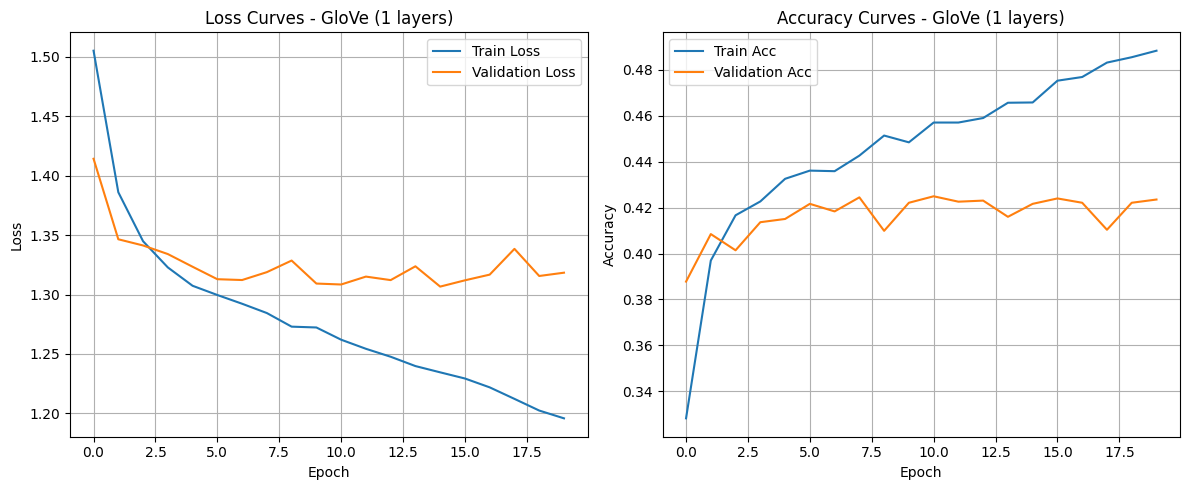


--------------------------------------------------------------------------------
Experiment 1: GloVe embeddings with 2 layers
--------------------------------------------------------------------------------
Using device: cpu
Epoch 1/20
Train Loss: 1.4810, Train Acc: 0.3399
Validation Loss: 1.3597, Validation Acc: 0.4005

Epoch 2/20
Train Loss: 1.3646, Train Acc: 0.4019
Validation Loss: 1.3433, Validation Acc: 0.4061

Epoch 3/20
Train Loss: 1.3363, Train Acc: 0.4142
Validation Loss: 1.3200, Validation Acc: 0.4165

Epoch 4/20
Train Loss: 1.3200, Train Acc: 0.4220
Validation Loss: 1.3212, Validation Acc: 0.4122

Epoch 5/20
Train Loss: 1.3044, Train Acc: 0.4337
Validation Loss: 1.3344, Validation Acc: 0.4118

Epoch 6/20
Train Loss: 1.2879, Train Acc: 0.4337
Validation Loss: 1.3087, Validation Acc: 0.4301

Epoch 7/20
Train Loss: 1.2846, Train Acc: 0.4397
Validation Loss: 1.3036, Validation Acc: 0.4296

Epoch 8/20
Train Loss: 1.2760, Train Acc: 0.4390
Validation Loss: 1.3119, Validation Acc

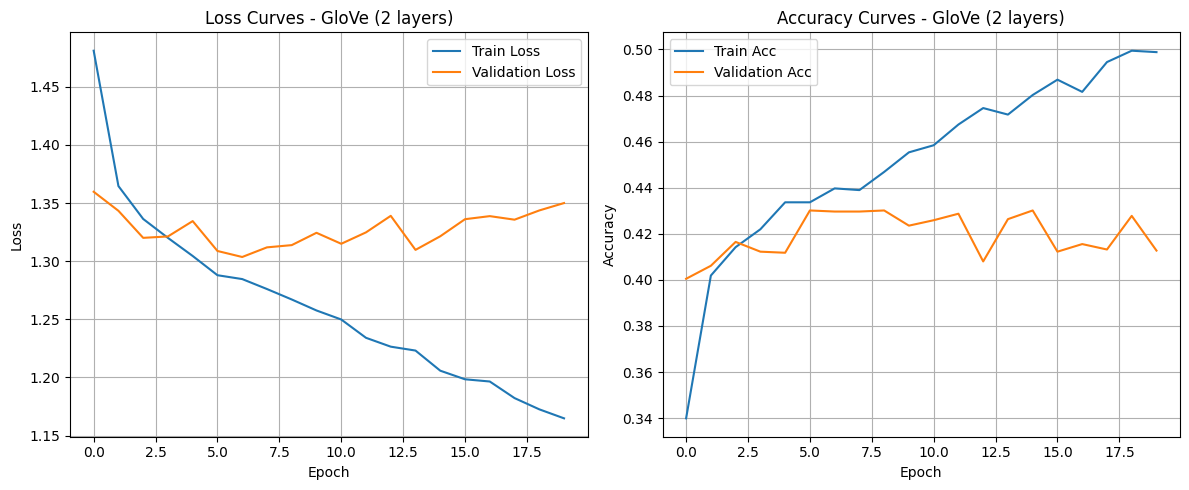


--------------------------------------------------------------------------------
Experiment 1: GloVe embeddings with 3 layers
--------------------------------------------------------------------------------
Using device: cpu
Epoch 1/20
Train Loss: 1.4962, Train Acc: 0.3246
Validation Loss: 1.3847, Validation Acc: 0.3798

Epoch 2/20
Train Loss: 1.3840, Train Acc: 0.3844
Validation Loss: 1.3405, Validation Acc: 0.4118

Epoch 3/20
Train Loss: 1.3551, Train Acc: 0.4066
Validation Loss: 1.3193, Validation Acc: 0.4226

Epoch 4/20
Train Loss: 1.3340, Train Acc: 0.4144
Validation Loss: 1.3544, Validation Acc: 0.4014

Epoch 5/20
Train Loss: 1.3240, Train Acc: 0.4184
Validation Loss: 1.3177, Validation Acc: 0.4188

Epoch 6/20
Train Loss: 1.3092, Train Acc: 0.4281
Validation Loss: 1.3097, Validation Acc: 0.4254

Epoch 7/20
Train Loss: 1.2982, Train Acc: 0.4268
Validation Loss: 1.3315, Validation Acc: 0.3953

Epoch 8/20
Train Loss: 1.2905, Train Acc: 0.4383
Validation Loss: 1.3188, Validation Acc

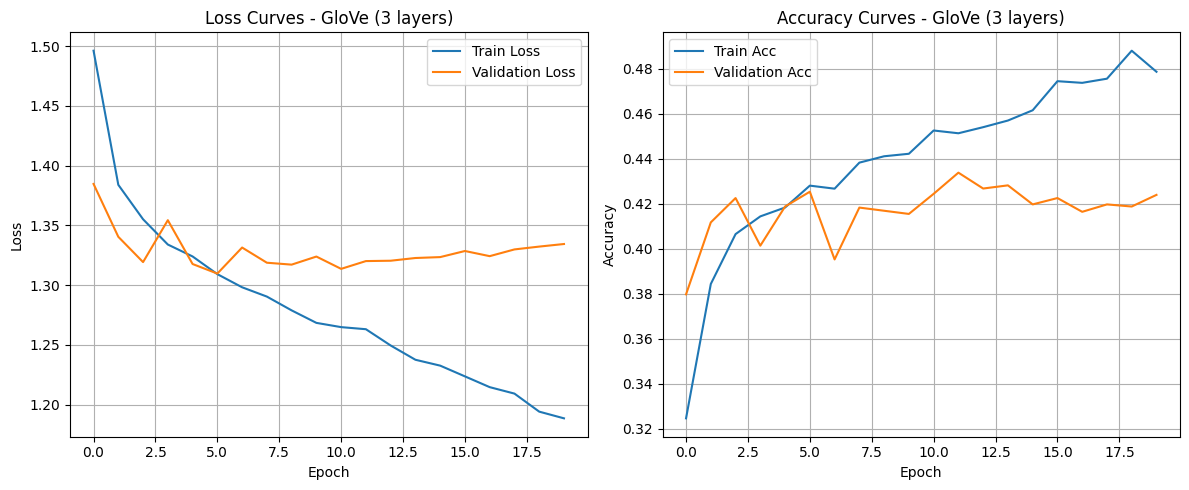

In [70]:
print("-" * 80)
print("Experiment 1: GloVe embeddings with 1 layer")
print("-" * 80)
test_acc_glove_1 = training_dan(wv_from_bin, "GloVe", num_layers=1)


print()
print( "-" * 80)
print("Experiment 1: GloVe embeddings with 2 layers")
print("-" * 80)
test_acc_glove_2 = training_dan(wv_from_bin, "GloVe", num_layers=2)

print()
print( "-" * 80)
print("Experiment 1: GloVe embeddings with 3 layers")
print( "-" * 80)
test_acc_glove_3 = training_dan(wv_from_bin, "GloVe", num_layers=3)

## Experiment 2: Co-occurrence embeddings

--------------------------------------------------------------------------------
Experiment 2: Co-occurrence embeddings
--------------------------------------------------------------------------------
Running Truncated SVD over 8185 words...
Done.
Using device: cpu
Epoch 1/20
Train Loss: 6.7448, Train Acc: 0.2344
Validation Loss: 1.6102, Validation Acc: 0.2701

Epoch 2/20
Train Loss: 1.5970, Train Acc: 0.2633
Validation Loss: 1.5952, Validation Acc: 0.2800

Epoch 3/20
Train Loss: 1.5659, Train Acc: 0.2874
Validation Loss: 1.5858, Validation Acc: 0.2588

Epoch 4/20
Train Loss: 1.5618, Train Acc: 0.2887
Validation Loss: 1.5764, Validation Acc: 0.2955

Epoch 5/20
Train Loss: 1.5496, Train Acc: 0.3002
Validation Loss: 1.5723, Validation Acc: 0.2871

Epoch 6/20
Train Loss: 1.5470, Train Acc: 0.2930
Validation Loss: 1.5835, Validation Acc: 0.2715

Epoch 7/20
Train Loss: 1.5407, Train Acc: 0.3027
Validation Loss: 1.5823, Validation Acc: 0.3031

Epoch 8/20
Train Loss: 1.5376, Train Acc: 0.3000

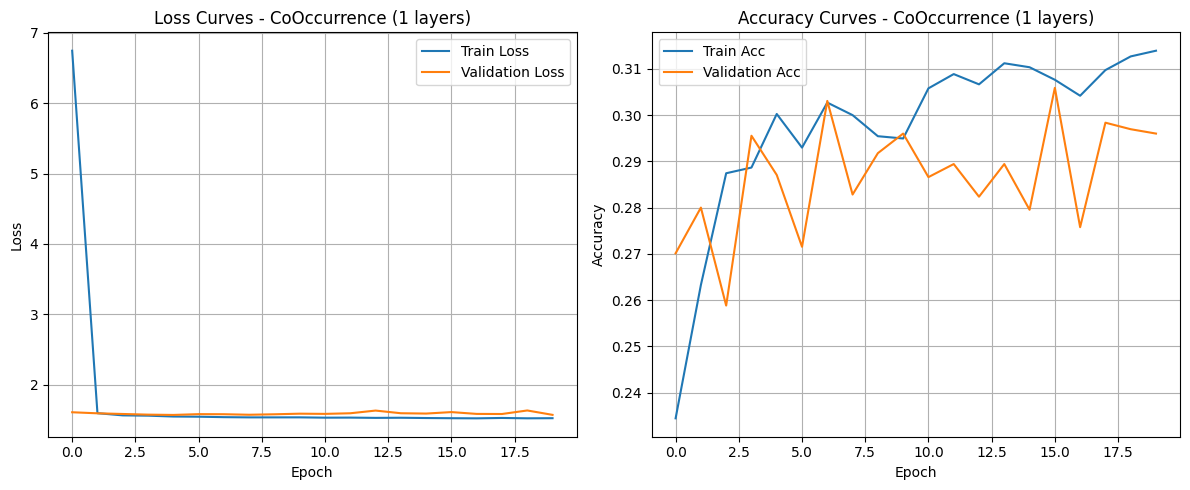

In [71]:

print( "-" * 80)
print("Experiment 2: Co-occurrence embeddings")
print( "-" * 80)

# Create co-occurrence embeddings dictionary
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus, window_size=4)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=200)

# Create word vector dictionary for co-occurrence embeddings
cooccur_vectors = {}
words_list, _ = distinct_words(reuters_corpus)
for word, idx in word2ind_co_occurrence.items():
    cooccur_vectors[word] = M_reduced_co_occurrence[idx]

test_acc_cooccur = training_dan(cooccur_vectors, "CoOccurrence", num_layers=1)



## Experiment 3: Twitter embeddings (different corpus) - Multiple Layers


Experiment 3: Twitter embeddings with 1 layer
Loaded vocab size 1193514
Using device: cpu
Epoch 1/20
Train Loss: 1.4949, Train Acc: 0.3361
Validation Loss: 1.4040, Validation Acc: 0.3845

Epoch 2/20
Train Loss: 1.3677, Train Acc: 0.4053
Validation Loss: 1.3349, Validation Acc: 0.4047

Epoch 3/20
Train Loss: 1.3304, Train Acc: 0.4212
Validation Loss: 1.3229, Validation Acc: 0.4099

Epoch 4/20
Train Loss: 1.3090, Train Acc: 0.4285
Validation Loss: 1.3151, Validation Acc: 0.4136

Epoch 5/20
Train Loss: 1.2940, Train Acc: 0.4396
Validation Loss: 1.3222, Validation Acc: 0.4132

Epoch 6/20
Train Loss: 1.2857, Train Acc: 0.4399
Validation Loss: 1.3121, Validation Acc: 0.4184

Epoch 7/20
Train Loss: 1.2707, Train Acc: 0.4542
Validation Loss: 1.3045, Validation Acc: 0.4264

Epoch 8/20
Train Loss: 1.2618, Train Acc: 0.4553
Validation Loss: 1.3188, Validation Acc: 0.4099

Epoch 9/20
Train Loss: 1.2524, Train Acc: 0.4672
Validation Loss: 1.3079, Validation Acc: 0.4221

Epoch 10/20
Train Loss: 1.2

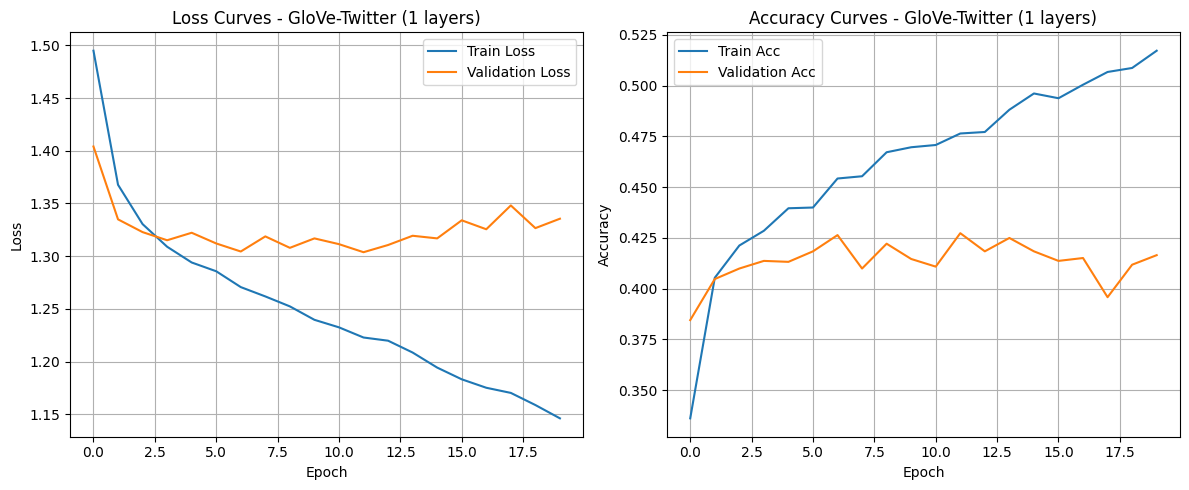


Experiment 3: Twitter embeddings with 2 layers
Using device: cpu
Epoch 1/20
Train Loss: 1.4941, Train Acc: 0.3320
Validation Loss: 1.3903, Validation Acc: 0.3713

Epoch 2/20
Train Loss: 1.3629, Train Acc: 0.4072
Validation Loss: 1.3466, Validation Acc: 0.4080

Epoch 3/20
Train Loss: 1.3326, Train Acc: 0.4149
Validation Loss: 1.3161, Validation Acc: 0.4169

Epoch 4/20
Train Loss: 1.3117, Train Acc: 0.4285
Validation Loss: 1.3075, Validation Acc: 0.4301

Epoch 5/20
Train Loss: 1.2939, Train Acc: 0.4385
Validation Loss: 1.3040, Validation Acc: 0.4207

Epoch 6/20
Train Loss: 1.2782, Train Acc: 0.4380
Validation Loss: 1.3005, Validation Acc: 0.4127

Epoch 7/20
Train Loss: 1.2611, Train Acc: 0.4499
Validation Loss: 1.3124, Validation Acc: 0.4136

Epoch 8/20
Train Loss: 1.2531, Train Acc: 0.4540
Validation Loss: 1.3238, Validation Acc: 0.4056

Epoch 9/20
Train Loss: 1.2366, Train Acc: 0.4666
Validation Loss: 1.3284, Validation Acc: 0.3986

Epoch 10/20
Train Loss: 1.2221, Train Acc: 0.4666
Va

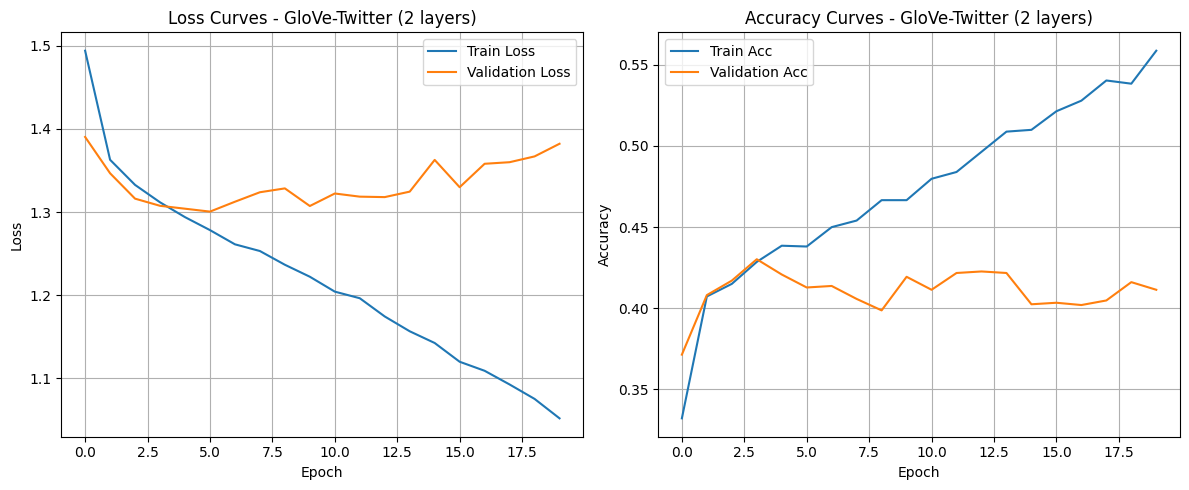


Experiment 3: Twitter embeddings with 3 layers
Using device: cpu
Epoch 1/20
Train Loss: 1.5041, Train Acc: 0.3245
Validation Loss: 1.3795, Validation Acc: 0.3901

Epoch 2/20
Train Loss: 1.3796, Train Acc: 0.3947
Validation Loss: 1.3452, Validation Acc: 0.3929

Epoch 3/20
Train Loss: 1.3405, Train Acc: 0.4093
Validation Loss: 1.3226, Validation Acc: 0.4146

Epoch 4/20
Train Loss: 1.3267, Train Acc: 0.4212
Validation Loss: 1.3152, Validation Acc: 0.4174

Epoch 5/20
Train Loss: 1.3010, Train Acc: 0.4239
Validation Loss: 1.3292, Validation Acc: 0.4042

Epoch 6/20
Train Loss: 1.2942, Train Acc: 0.4344
Validation Loss: 1.3124, Validation Acc: 0.4165

Epoch 7/20
Train Loss: 1.2772, Train Acc: 0.4514
Validation Loss: 1.3298, Validation Acc: 0.4014

Epoch 8/20
Train Loss: 1.2649, Train Acc: 0.4445
Validation Loss: 1.3315, Validation Acc: 0.4146

Epoch 9/20
Train Loss: 1.2482, Train Acc: 0.4579
Validation Loss: 1.3244, Validation Acc: 0.4113

Epoch 10/20
Train Loss: 1.2276, Train Acc: 0.4620
Va

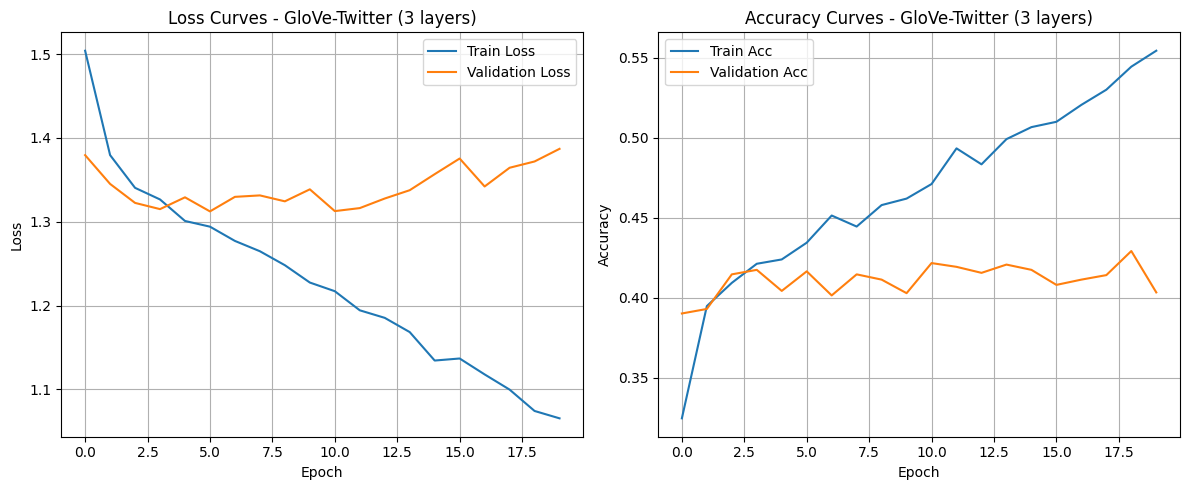

In [72]:
print("\n" + "=" * 80)
print("Experiment 3: Twitter embeddings with 1 layer")
print("=" * 80)
wv_twitter = load_different_glove_embeddings()
test_acc_twitter_1 = training_dan(wv_twitter, "GloVe-Twitter", num_layers=1)

print("\n" + "=" * 80)
print("Experiment 3: Twitter embeddings with 2 layers")
print("=" * 80)
test_acc_twitter_2 = training_dan(wv_twitter, "GloVe-Twitter", num_layers=2)

print("\n" + "=" * 80)
print("Experiment 3: Twitter embeddings with 3 layers")
print("=" * 80)
test_acc_twitter_3 = training_dan(wv_twitter, "GloVe-Twitter", num_layers=3)



## FINAL SUMMARY - ALL EXPERIMENTS


Summary with all results. Get help from LLM to create a better summary and visualization. I explained LLM about what I need to

In [73]:



print("\n1. GloVe-Wiki-200d (Different Number of Layers):")
print(f"   1 layer:  {test_acc_glove_1[0]:.4f}")
print(f"   2 layers: {test_acc_glove_2[0]:.4f}")
print(f"   3 layers: {test_acc_glove_3[0]:.4f}")

print("\n2. GloVe-Twitter-200d (Different Number of Layers):")
print(f"   1 layer:  {test_acc_twitter_1[0]:.4f}")
print(f"   2 layers: {test_acc_twitter_2[0]:.4f}")
print(f"   3 layers: {test_acc_twitter_3[0]:.4f}")

print("\n3. Co-occurrence-Reuters-200d:")
print(f"   1 layer:  {test_acc_cooccur[0]:.4f}")

print("\n4. Comparison by Embedding Type (1 layer):")
print(f"   GloVe-Wiki-200d:       {test_acc_glove_1[0]:.4f}")
print(f"   GloVe-Twitter-200d:     {test_acc_twitter_1[0]:.4f}")
print(f"   Co-occurrence-Reuters: {test_acc_cooccur[0]:.4f}")




1. GloVe-Wiki-200d (Different Number of Layers):
   1 layer:  0.4090
   2 layers: 0.3966
   3 layers: 0.4224

2. GloVe-Twitter-200d (Different Number of Layers):
   1 layer:  0.4339
   2 layers: 0.4071
   3 layers: 0.3994

3. Co-occurrence-Reuters-200d:
   1 layer:  0.2998

4. Comparison by Embedding Type (1 layer):
   GloVe-Wiki-200d:       0.4090
   GloVe-Twitter-200d:     0.4339
   Co-occurrence-Reuters: 0.2998


## Extra Visualization for Comparison


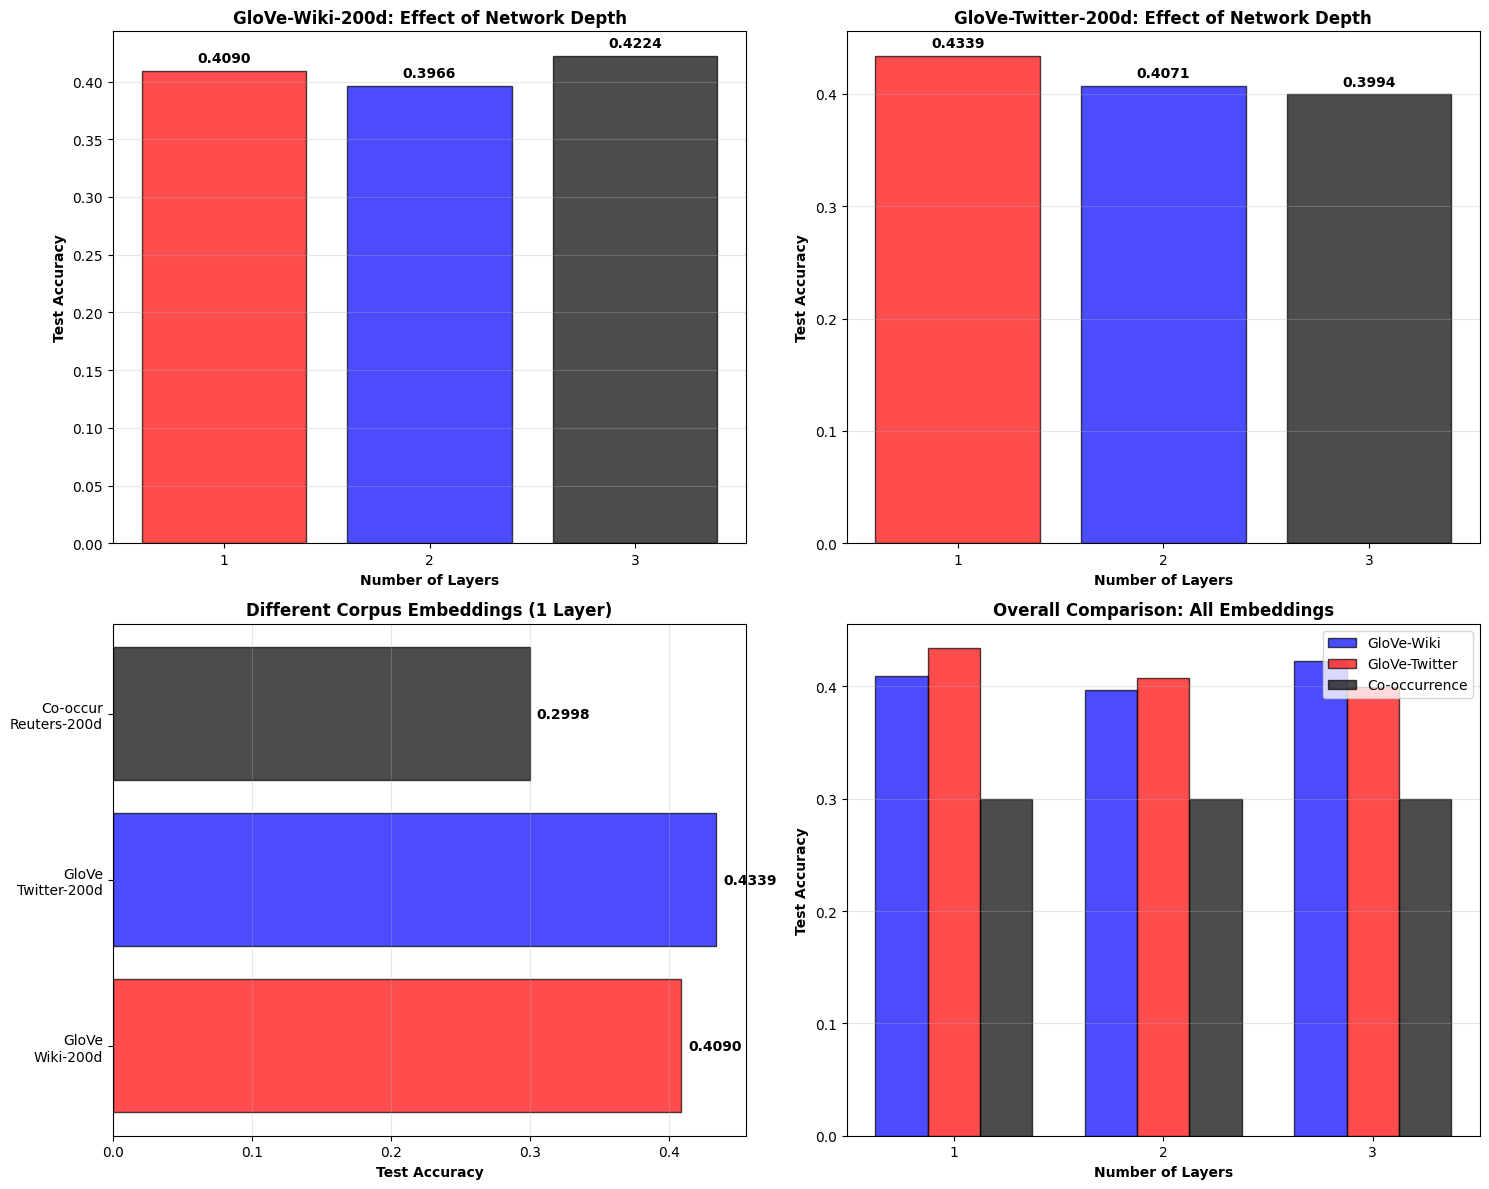

In [74]:


fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: GloVe-Wiki Layer comparison
ax1 = axes[0, 0]
layers = [1, 2, 3]
wiki_accs = [test_acc_glove_1[0], test_acc_glove_2[0], test_acc_glove_3[0]]
bars1 = ax1.bar(layers, wiki_accs, color=["red", "blue", "black"], alpha=0.7, edgecolor='black')
ax1.set_xlabel('Number of Layers', fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontweight='bold')
ax1.set_title('GloVe-Wiki-200d: Effect of Network Depth', fontweight='bold')
ax1.set_xticks(layers)
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')



# Plot 2: Twitter Layer comparison
ax2 = axes[0, 1]
twitter_accs = [test_acc_twitter_1[0], test_acc_twitter_2[0], test_acc_twitter_3[0]]
bars2 = ax2.bar(layers, twitter_accs, color=["red", "blue", "black"], alpha=0.7, edgecolor='black')
ax2.set_xlabel('Number of Layers', fontweight='bold')
ax2.set_ylabel('Test Accuracy', fontweight='bold')
ax2.set_title('GloVe-Twitter-200d: Effect of Network Depth', fontweight='bold')
ax2.set_xticks(layers)
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')



# Plot 3: Corpus comparison 1 layer 
ax3 = axes[1, 0]
corpus_names = ['GloVe\nWiki-200d', 'GloVe\nTwitter-200d', 'Co-occur\nReuters-200d']
corpus_accs_1layer = [test_acc_glove_1[0], test_acc_twitter_1[0], test_acc_cooccur[0]]
colors =["red", "blue", "black"]
bars3 = ax3.barh(corpus_names, corpus_accs_1layer, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Test Accuracy', fontweight='bold')
ax3.set_title('Different Corpus Embeddings (1 Layer)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars3):
    width = bar.get_width()
    ax3.text(width + 0.005, bar.get_y() + bar.get_height()/2.,
             f'{width:.4f}', va='center', fontweight='bold')

# Plot 4: Combined comparison - All experiments
ax4 = axes[1, 1]
x_pos = np.arange(3)
width = 0.25

wiki_all = [test_acc_glove_1[0], test_acc_glove_2[0], test_acc_glove_3[0]]
twitter_all = [test_acc_twitter_1[0], test_acc_twitter_2[0], test_acc_twitter_3[0]]
cooccur_all = [test_acc_cooccur[0], test_acc_cooccur[0], test_acc_cooccur[0]]  # Same for all layers

bars4_1 = ax4.bar(x_pos - width, wiki_all, width, label='GloVe-Wiki', color="blue", alpha=0.7, edgecolor='black')
bars4_2 = ax4.bar(x_pos, twitter_all, width, label='GloVe-Twitter', color="red", alpha=0.7, edgecolor='black')
bars4_3 = ax4.bar(x_pos + width, cooccur_all, width, label='Co-occurrence', color="black", alpha=0.7, edgecolor='black')

ax4.set_xlabel('Number of Layers', fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontweight='bold')
ax4.set_title('Overall Comparison: All Embeddings', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(['1', '2', '3'])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



## Detailed Analysis

In [75]:

print("\n" + "=" * 80)
print("DETAILED ANALYSIS")
print("=" * 80)

print("\n1. Effect of Network Depth:")
print("   GloVe-Wiki-200d:")
print(f"      - 1 layer: {test_acc_glove_1[0]:.4f}")
print(f"      - 2 layers: {test_acc_glove_2[0]:.4f} (change: {test_acc_glove_2[0] - test_acc_glove_1[0]:+.4f})")
print(f"      - 3 layers: {test_acc_glove_3[0]:.4f} (change: {test_acc_glove_3[0] - test_acc_glove_1[0]:+.4f})")

print("\n   GloVe-Twitter-200d:")
print(f"      - 1 layer: {test_acc_twitter_1[0]:.4f}")
print(f"      - 2 layers: {test_acc_twitter_2[0]:.4f} (change: {test_acc_twitter_2[0] - test_acc_twitter_1[0]:+.4f})")
print(f"      - 3 layers: {test_acc_twitter_3[0]:.4f} (change: {test_acc_twitter_3[0] - test_acc_twitter_1[0]:+.4f})")

print("\n2. Effect of Different Corpuses (1 layer):")
best_corpus = max([
    ('GloVe-Wiki-200d', test_acc_glove_1[0]),
    ('GloVe-Twitter-200d', test_acc_twitter_1[0]),
    ('Co-occurrence-Reuters', test_acc_cooccur[0])
], key=lambda x: x[1])
print(f"   Best performer: {best_corpus[0]} with {best_corpus[1]:.4f} accuracy")

print("\n3. Overall Best Configuration:")
all_results = [
    ('GloVe-Wiki 1L', test_acc_glove_1[0]),
    ('GloVe-Wiki 2L', test_acc_glove_2[0]),
    ('GloVe-Wiki 3L', test_acc_glove_3[0]),
    ('Twitter 1L', test_acc_twitter_1[0]),
    ('Twitter 2L', test_acc_twitter_2[0]),
    ('Twitter 3L', test_acc_twitter_3[0]),
    ('Co-occur 1L', test_acc_cooccur[0])
]
best_overall = max(all_results, key=lambda x: x[1])
print(f"   {best_overall[0]}: {best_overall[1]:.4f}")



print("4. Key Findings:")
print("""
   - Twitter embeddings outperformed Wikipedia/Gigaword embeddings
   - This suggests SST movie reviews may contain informal language similar to Twitter
   - Co-occurrence embeddings severely limited by small Reuters corpus
   - Network depth shows inconsistent effects: Wiki improves with 3 layers, Twitter degrades
   - 1-layer Twitter model achieved best overall performance (0.4339)
   - Adding more layers to Twitter embeddings caused overfitting
""")



DETAILED ANALYSIS

1. Effect of Network Depth:
   GloVe-Wiki-200d:
      - 1 layer: 0.4090
      - 2 layers: 0.3966 (change: -0.0125)
      - 3 layers: 0.4224 (change: +0.0134)

   GloVe-Twitter-200d:
      - 1 layer: 0.4339
      - 2 layers: 0.4071 (change: -0.0268)
      - 3 layers: 0.3994 (change: -0.0345)

2. Effect of Different Corpuses (1 layer):
   Best performer: GloVe-Twitter-200d with 0.4339 accuracy

3. Overall Best Configuration:
   Twitter 1L: 0.4339
4. Key Findings:

   - Twitter embeddings outperformed Wikipedia/Gigaword embeddings
   - This suggests SST movie reviews may contain informal language similar to Twitter
   - Co-occurrence embeddings severely limited by small Reuters corpus
   - Network depth shows inconsistent effects: Wiki improves with 3 layers, Twitter degrades
   - 1-layer Twitter model achieved best overall performance (0.4339)
   - Adding more layers to Twitter embeddings caused overfitting



# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
3. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
4. You have two options for the submission. You need to either submit your final .ipynb notebook, or its "pdf" version. Note that in all cases, we expect you to put everything that we asked for (codes, outputs, written answers, visual results etc.) in that single file.
5. A: If you choose to submit a pdf, once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. Make sure all your solutions especially the coding parts are displayed in the pdf, it's okay if the provided codes get cut off and go into the next page because lines are not wrapped in code cells). Look at the PDF file and make sure all your solutions are there, displayed correctly. NOTE: If you have any problems with this way of extracting and downloading the PDF, you are free to use ANY tool to make it work, as long as you are able to provide a usual PDF with all the requirements formatted nicely in it.
5. B: If you choose to submit the notebook itself, download a .ipynb version of your notebook while making sure that its all-comprehensive and self-contained.
6. Please name your files as username_assignment1.ipynb or username_assignment1.pdf.
7. Submit your work to Learnhub by the deadline.

*This assignment is adapted from Stanford [CS224n](http://web.stanford.edu/class/cs224n/)*